<a href="https://colab.research.google.com/github/zahraDehghanian97/ddcrp_Cora/blob/master/ddcrp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=2932a3c4e877f09f28f36c88e65914cb43b5d390d91abbe6cd0649c229f769f5
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [6]:
from torch_geometric.datasets import Planetoid
import numpy as np
from numpy import seterr, isneginf, array
from scipy.special import gammaln
from scipy.special import logsumexp


dataset = Planetoid("/content/sample_data/Cora" , name = 'Cora')

Processing...
Done!


In [55]:
print(dataset.data.keys)
x = dataset.data.x.detach().cpu().numpy()[0:100]
y = dataset.data.y.detach().cpu().numpy()[0:100]

# x = np.array([[10,0,0,0,0],[10,0,0,0,0],[5,0,0,0,0],[11,0,0,0,1],[0,10,0,0,1],[0,10,0,0,0],[0,0,10,0,0],[0,1,10,0,0],[20,0,2,0,0],[10,0,0,1,0],[10,1,0,10,0],[10,0,2,10,0],[10,0,0,10,0],[10,1,0,1,0],[10,0,0,0,0],])


['x', 'edge_index', 'train_mask', 'test_mask', 'val_mask', 'y']


In [57]:

def dirichlet_likelihood(Xp, hyper):
    if len(Xp.shape) == 2:
        X =sum(Xp)
    else:
        X = Xp
    idx = np.where(X!=0)
    lh = gammaln(len(X)*hyper) + sum(gammaln(X[idx]+hyper))\
    -len(idx)*gammaln(hyper)  - gammaln(sum(X)+len(X) * hyper)
    return lh



hyper = 0.001 #0.2
lhood_fn = lambda x:dirichlet_likelihood(x,hyper)


In [58]:
def window_delay(a,size=1):
    if abs(a) <= size and a >= 0:
        return 1;
    else:
        return 0;



window_size = 20 #20
delay = lambda x:window_delay(x,window_size)


In [69]:
def linear_distance(i,j):
    return i-j


#get the customers linked to customer i
def get_linked(i,link):
    c = []
    q = []
    q.append(i)
    while q:
        cur = q[0]
        c.append(cur)
        for k in range(0,len(link)):
            if (link[k] == cur) and (k not in c) and (k not in q):
                q.append(k)
        q = q[1:]
    return c

def ddcrp_infer(obs,lhood_fn,distance,delay,n_iter,alpha = 0.2):
    liklihoods = []
    n = len(obs)
    cluster = np.array([0]*n)
    link = np.array([0]*n)
    prior = np.random.random(n*n).reshape((n,n))
    #lhood = np.random.random(n)
    merged_lhood = np.random.random(n)
    lhood = list(map(lambda x: lhood_fn(obs[np.where(cluster == x)]) , cluster))  #lhood of each cluster

    obs_lhood = 0 #the likelihood of all obs

    #prior of each customer
    for i in range(0,n):
        for j in range(0,n):
            try:
                if i==j:
                    prior[i][j] = np.log(alpha)
                else:
                    seterr(divide='ignore')
                    prior[i][j] = np.log(delay(distance(i,j)))
                    seterr(divide='warn')
                    prior[i][j][isneginf(prior[i][j])] = 0
            except Exception as e:
                # print(e)
                pass


    for t in range(0,n_iter):
        print("iter "+str(t))
        obs_lhood = 0
        for i in range(0,n):
            #print ("sample"+str(i)+"th:")
            #remove the ith's link
            old_link = link[i]
            old_cluster = cluster[old_link]
            cluster[i] = i
            link[i] = i
            linked = get_linked(i,link)
            # print(linked)
            cluster[linked] = i

            if old_cluster not in linked :
                idx = np.where(cluster == old_cluster)
                lhood[old_cluster] = lhood_fn(obs[idx])
                lhood[i] = lhood_fn(obs[linked])


            #calculate the likelihood of the merged cluster
            for j in np.unique(cluster):

                if j == cluster[i] :
                    merged_lhood[j] = 2*lhood_fn(obs[linked])
                else:
                    merged_lhood[j] = lhood_fn(np.concatenate((obs[linked] , obs[np.where(cluster == j)])))

            log_prob = list(map(lambda x: prior[i][x] + merged_lhood[cluster[x]] - lhood[cluster[x]]-lhood[cluster[i]], np.arange(n)))
            prob = np.exp(log_prob - logsumexp(log_prob))

            #sample z_i
            link[i] = np.random.choice(np.arange(n),1,p=prob)

            #update the likelihood if the link sample merge two cluster
            new_cluster = cluster[link[i]]
            if new_cluster !=i:
                cluster[linked] = new_cluster
                lhood[new_cluster] = merged_lhood[new_cluster]

            #cal the likelihood of all obs
            for u in np.unique(cluster):
                obs_lhood = obs_lhood + lhood[u]

        print("cluster")
        print(cluster)
        # print("link")
        # print(link)
        liklihoods.append(obs_lhood)

    return cluster,link,liklihoods

In [70]:

n_iter =50 #200
alpha = 0.0000000000000001  #0.2

distance = linear_distance
cluster,link,lhood = ddcrp_infer(x,lhood_fn,distance,delay,n_iter,alpha)


iter 0
cluster
[ 0  1  1  1  1  1  1  1  8  8  8  8  8 13 13 13  8 13  8 13 20 20 20  8
 20 25 25 25 25 20 30 30 30 33 33 33 30 37 37 37 40 40 40 40 33 45 45 45
 45 49 49 49 33 37 37 55 55 55 45 55 49 45 33 63 63 63 55 49 63 33 63 71
 71 71 71 71 76 76 76 76 49 81 81 81 81 55 86 86 86 89 89 89 92 92 92 92
 96 96 96 96]
iter 1
cluster
[ 0  0  2  3  2  0  3  2  8  9  8  9  3 13 14 13 14  9  2 13 20 20 22 14
 22 25 26 25 26 25 30 30 26 33 34 33 14 37 38 38 40 37 40 40 34 45 45 47
 45 49 50 37 34 33 37 55 40 57 55 47 57 55 49 63 55 45 47 50 34 49 63 71
 72 71 72 72 76 63 76 71 50 81 81 76 81 47 86 72 86 89 89 81 92 72 89 92
 96 97 97 96]
iter 2
cluster
[ 0  0  2  3  2  0  3  0  8  9  8  9  2 13 14  8  3  9  8 13 20 20 22 14
 22 25 26 25  9 13 30 30 26 33 34 13 14 37 38 38 40 26 25 40 33 45 45 47
 30 49 50 37 34 34 40 55 33 57 55 40 57 47 49 63 55 45 47 50 45 49 63 71
 72 71 57 72 76 63 76 71 50 81 57 55 81 47 86 72 86 89 89 76 92 57 86 92
 96 97 97 96]
iter 3
cluster
[ 0  0  2  3  2  2  3 

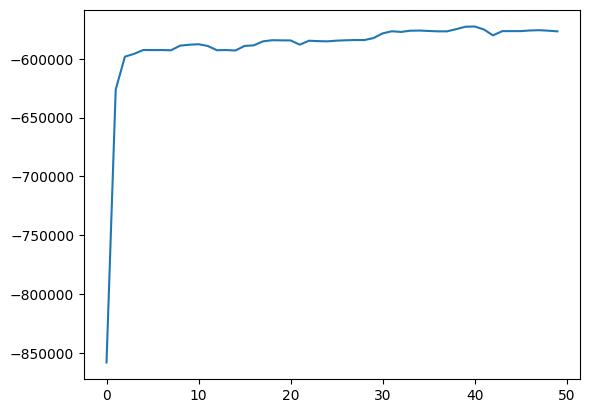

In [71]:
import matplotlib.pyplot as plt
plt.plot(lhood)
plt.show()

diffrent mesurment option for clustering 

such as NMI , purity.

In [72]:
import numpy as np
from sklearn.metrics import accuracy_score

def purity_score(y_true, y_pred):
    y_voted_labels = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    labels = np.unique(y_true)
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    return accuracy_score(y_true, y_voted_labels)

print(purity_score(y, np.array(cluster)))

0.51


In [73]:
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y,cluster))

0.3815090524134604
